# Checking grid effects in Gabet et al 2021, JGR-ES

These are the routines for checking for grid effects in the Gabet et al 2021 paper. 
This notebook contains some additional analyses looking at the effect of the diameter of the fitting window. 

In [1]:
import hillslopetoy as ht
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os

In [2]:
def power_fxn(E,a,b):
    C = a*(E**b)
    return C

In [3]:
def get_fit_and_label(xdata,ydata):
    '''
    This is a simple function for extracting a power law fit from data
    You feed in the data and then you get back out both the fit as well
    as a string that can be used to label plots.

    Author: SMM

    Date: 30/11/2020
    '''
    popt, pcov = curve_fit(power_fxn,xdata,ydata, p0=(0.6082,0.5))
    residuals = ydata- power_fxn(xdata, popt[0],popt[1])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared_field2 = 1 - (ss_res / ss_tot)
    fit_ydata = power_fxn(xdata, popt[0],popt[1])

    round_p0 = np.around(popt[0],2)
    round_p1 = np.around(popt[1],2)
    round_r2 = np.around(r_squared_field2,2)

    sp0 = str(round_p0)
    sp1 = str(round_p1)
    sr2 = str(round_r2)

    power_string = r'$%s*E^{%s}, r^2 = %s$' % (sp0,sp1,sr2)

    return [fit_ydata,power_string]

In [4]:
def extract_apparent_D(data_filename_prefix,use_brents = False, window_radius = 6, n_iters = 250):
    """
    This function reads a file with erosion rates and curvatures, and then calculates a naive calculation of
    D as well as a value of D correct for grid effects. 
 
     Args:
        data_filename_prefix (string): Prefix of the csv with the data
        use_brents (bool): Sometimes the toms748 algorithm does not converge and you get an error. If that happens, you need to make this true which is slower but more stable

    Returns:
        The name of the output file
    
    Author: SMM

    Date: 30/11/2020, This version updated for ipython 04/05/2021   
    """
    
    print("I am going to see how badly grid effects mess up your results.")
    
    input_file = data_filename_prefix+".csv"
    if use_brents:
        output_file = data_filename_prefix+"_brents_"+str(window_radius)+"_iters_"+str(n_iters)+"_uncert.csv"
    else:
        output_file = data_filename_prefix+"_toms_"+str(window_radius)+"_iters_"+str(n_iters)+"_uncert.csv"
        
    data = np.loadtxt(input_file,delimiter=",",skiprows=1)
    print(data)

    calc_D = []

    for row in data:
        original_data = []
        original_data.append(row[0])
        original_data.append(row[1])
        original_data.append(row[2])
        meas_erosion = row[0]/1000000     # I need to do this to make sure everything is in m/yr
        meas_curv = row[1]
        print(str(meas_erosion)+"  "+str(meas_curv))
        apparent_D = ht.calculate_apparent_D_with_noise(meas_erosion,meas_curv,half_length = 6, spacing = 1, S_c = 1.0, rho_ratio=2,topographic_uncert = 0.2, n_iterations = n_iters, use_brents = use_brents)
        apparent_D= [element*1000 for element in apparent_D]  # A unit conversion for the D values so they are reported in m^2/kyr 
        apparent_D[0:0] = original_data
        print(apparent_D)
        calc_D.append(apparent_D)
        

    np.savetxt(output_file, calc_D, comments='', delimiter=",",header="erate (mm/kyr),measured curvature (1/m),naive D (m2/kyr),minimum D (m2/kyr),16th percentile D (m2/kyr),median D (m2/kyr),84th percentile D (m2/kyr),maximum D (m2/kyr),")
    return output_file 

In [5]:
%matplotlib inline
def plot_results(data_filename):
    '''
    This plots the results of the uncertainty analysis.
    You need to extract_apparent_D before you plot the results
    since this function reads a file created by
    extract_apparent_D
    
    Args:
        data_filename (string): the filename of the data. This is returned by extract_apparent_D
        
    Author: SMM

    Date: 30/11/2020
    '''

    datadf = pd.read_csv(data_filename)

    # first we need a fit
    Erate = datadf['erate (mm/kyr)'].to_numpy()
    naive_D = datadf['naive D (m2/kyr)'].to_numpy()

    median_D = datadf['median D (m2/kyr)'].to_numpy()
    D16 = datadf['16th percentile D (m2/kyr)'].to_numpy()
    D84 = datadf['84th percentile D (m2/kyr)'].to_numpy()
    max_D = datadf['maximum D (m2/kyr)'].to_numpy()
    min_D = datadf['minimum D (m2/kyr)'].to_numpy()

    D16err = np.subtract(median_D,D16)
    D84err = np.subtract(D84,median_D)

    min_err = np.subtract(median_D,min_D)
    max_err = np.subtract(max_D,median_D)

    errors = np.vstack((D16err,D84err))
    errors2= np.vstack((min_err,max_err))

    # Get the fit to the truncated field data
    datadf2 = datadf[datadf['erate (mm/kyr)'] < 400]

    # first we need a fit
    Erate2 = datadf2['erate (mm/kyr)'].to_numpy()
    naive_D2 = datadf2['naive D (m2/kyr)'].to_numpy()

    median_D2 = datadf2['median D (m2/kyr)'].to_numpy()
    D162 = datadf2['16th percentile D (m2/kyr)'].to_numpy()
    D842 = datadf2['84th percentile D (m2/kyr)'].to_numpy()

    popt, pcov = curve_fit(power_fxn,Erate2,naive_D2, p0=(0.6082,0.5))

    residuals = naive_D2- power_fxn(Erate2, popt[0],popt[1])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((naive_D2-np.mean(naive_D2))**2)
    r_squared_field2 = 1 - (ss_res / ss_tot)
    fit_D2 = power_fxn(Erate2, popt[0],popt[1])
    #print(r_squared_field2)

    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    ax.scatter(Erate, naive_D,label="$D$ directly from $E$ and $C$", color='g',alpha = 0.5)
    ax.errorbar(Erate, median_D, yerr=errors, fmt='ro',label = "$D$ corrected for grid resolution")

    [fit_ydata,power_string1] = get_fit_and_label(Erate2,naive_D2)
    #power_string1 = power_string1+", exculding 2 outliers"
    ax.plot(Erate2,fit_ydata,linestyle=":",alpha = 0.6,label=power_string1)

    [fit_ydata2,power_string2] = get_fit_and_label(Erate2,median_D2)
    power_string2 = power_string2+", corrected"
    ax.plot(Erate2,fit_ydata2,linestyle=":",alpha = 0.6,label=power_string2)

    [fit_ydata3,power_string3] = get_fit_and_label(Erate,naive_D)
    ax.plot(Erate,fit_ydata3,linestyle="-",alpha = 1,label=power_string3)

    [fit_ydata4,power_string4] = get_fit_and_label(Erate,median_D)
    power_string4 = power_string4+", corrected"
    ax.plot(Erate,fit_ydata4,linestyle="-",alpha = 1,label=power_string4)


    ax.set(xlabel='Erosion rate, $E$ (mm/kyr)', ylabel='Transport coefficient, $D$ (m$^2$/kyr)')
    ax.grid()
    ax.legend()

    ax = ht.axis_styler(ax,axis_style="Normal")

    plt.yscale("log")
    plt.xscale("log")
    

    new_fname = os.path.splitext(data_filename)[0]+'.png'
    fig.savefig(new_fname,dpi=300)

I am going to see how badly grid effects mess up your results.
[[ 3.6500e+01 -2.5360e-02  2.9000e+00]
 [ 6.1500e+01 -2.4700e-02  5.0000e+00]
 [ 8.4900e+01 -3.3340e-02  5.1000e+00]
 [ 9.2500e+01 -3.9020e-02  4.7000e+00]
 [ 5.5000e+01 -3.1710e-02  3.5000e+00]
 [ 1.0100e+02 -6.5020e-02  3.1000e+00]
 [ 3.7000e+01 -2.1500e-02  3.4000e+00]
 [ 7.8000e+01 -3.0120e-02  5.2000e+00]
 [ 3.5000e+01 -1.0380e-02  6.7000e+00]
 [ 9.2150e+02 -7.1590e-02  2.5700e+01]
 [ 8.0080e+02 -1.2596e-01  1.2700e+01]
 [ 1.7680e+02 -4.6240e-02  7.6000e+00]
 [ 2.2490e+02 -4.5250e-02  9.9000e+00]
 [ 1.4350e+02 -4.2430e-02  6.8000e+00]
 [ 2.3200e+01 -1.3780e-02  3.4000e+00]
 [ 5.7000e+00 -6.8200e-03  1.7000e+00]
 [ 9.9000e+00 -1.7100e-02  1.2000e+00]
 [ 1.2600e+01 -1.2220e-02  2.1000e+00]
 [ 3.2700e+01 -2.0280e-02  3.2000e+00]
 [ 3.4800e+01 -2.0220e-02  3.4000e+00]
 [ 3.8100e+01 -1.9780e-02  3.9000e+00]
 [ 5.2900e+01 -2.0650e-02  5.1000e+00]
 [ 3.9500e+01 -1.9710e-02  4.0000e+00]
 [ 8.5400e+01 -2.5190e-02  6.8000e+00]
 

Range of D:
[0.0027575522407316524, 0.0032681728065937104, 0.0037615255603666896]
[32.7, -0.02028, 3.2, 2.7575522407316524, 3.071336367418686, 3.2681728065937103, 3.5066389936532523, 3.7615255603666897]
3.48e-05  -0.02022
The apparent D is:0.003442136498516321 or 3.4421364985163208 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.002897527981591425, 0.0033814479791504405, 0.0044102019182094086]
[34.8, -0.02022, 3.4, 2.8975279815914248, 3.2296009874748295, 3.3814479791504404, 3.6717699968327873, 4.410201918209409]
3.8100000000000005e-05  -0.01978
The apparent D is:0.0038523761375126395 or 3.8523761375126395 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.0033350741313129093, 0.003771926610692511, 0.004403828070686892]
[38.1, -0.01978, 3.9, 3.335074131312909, 3.5461420617569157, 3.771926610692511, 4.079501915881626, 4.403828070686893]
5.29e-05  -0.02065
The apparen

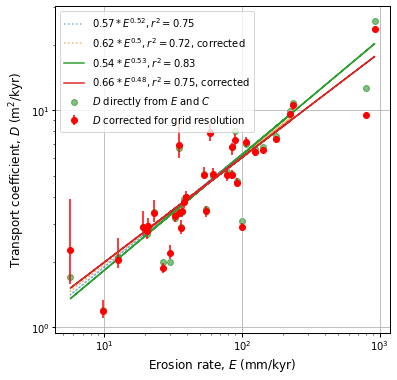

In [12]:
output_file = extract_apparent_D("manny_data_v3",use_brents = False, window_radius = 6, n_iters = 25)
plot_results(output_file)

I am going to see how badly grid effects mess up your results.
[[ 3.6500e+01 -2.5360e-02  2.9000e+00]
 [ 6.1500e+01 -2.4700e-02  5.0000e+00]
 [ 8.4900e+01 -3.3340e-02  5.1000e+00]
 [ 9.2500e+01 -3.9020e-02  4.7000e+00]
 [ 5.5000e+01 -3.1710e-02  3.5000e+00]
 [ 1.0100e+02 -6.5020e-02  3.1000e+00]
 [ 3.7000e+01 -2.1500e-02  3.4000e+00]
 [ 7.8000e+01 -3.0120e-02  5.2000e+00]
 [ 3.5000e+01 -1.0380e-02  6.7000e+00]
 [ 9.2150e+02 -7.1590e-02  2.5700e+01]
 [ 8.0080e+02 -1.2596e-01  1.2700e+01]
 [ 1.7680e+02 -4.6240e-02  7.6000e+00]
 [ 2.2490e+02 -4.5250e-02  9.9000e+00]
 [ 1.4350e+02 -4.2430e-02  6.8000e+00]
 [ 2.3200e+01 -1.3780e-02  3.4000e+00]
 [ 5.7000e+00 -6.8200e-03  1.7000e+00]
 [ 9.9000e+00 -1.7100e-02  1.2000e+00]
 [ 1.2600e+01 -1.2220e-02  2.1000e+00]
 [ 3.2700e+01 -2.0280e-02  3.2000e+00]
 [ 3.4800e+01 -2.0220e-02  3.4000e+00]
 [ 3.8100e+01 -1.9780e-02  3.9000e+00]
 [ 5.2900e+01 -2.0650e-02  5.1000e+00]
 [ 3.9500e+01 -1.9710e-02  4.0000e+00]
 [ 8.5400e+01 -2.5190e-02  6.8000e+00]
 

Range of D:
[0.0029157946465428394, 0.003303286745595393, 0.004044300312741014]
[32.7, -0.02028, 3.2, 2.9157946465428393, 3.114258837740489, 3.303286745595393, 3.505142965638679, 4.044300312741014]
3.48e-05  -0.02022
The apparent D is:0.003442136498516321 or 3.4421364985163208 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.0031267503195183148, 0.0034721772860774845, 0.004141268215122217]
[34.8, -0.02022, 3.4, 3.126750319518315, 3.2383984380666764, 3.4721772860774847, 3.735833713537687, 4.141268215122217]
3.8100000000000005e-05  -0.01978
The apparent D is:0.0038523761375126395 or 3.8523761375126395 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.0031183530042878053, 0.003775997591203301, 0.004819405746537364]
[38.1, -0.01978, 3.9, 3.118353004287805, 3.5226468302078455, 3.775997591203301, 4.092963537112015, 4.819405746537364]
5.29e-05  -0.02065
The apparent D is:

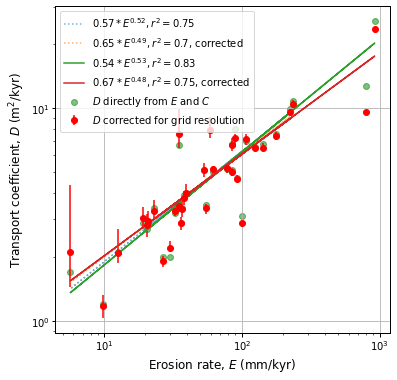

In [11]:
output_file = extract_apparent_D("manny_data_v3",use_brents = False, window_radius = 4, n_iters = 25)
plot_results(output_file)

I am going to see how badly grid effects mess up your results.
[[ 3.6500e+01 -2.5360e-02  2.9000e+00]
 [ 6.1500e+01 -2.4700e-02  5.0000e+00]
 [ 8.4900e+01 -3.3340e-02  5.1000e+00]
 [ 9.2500e+01 -3.9020e-02  4.7000e+00]
 [ 5.5000e+01 -3.1710e-02  3.5000e+00]
 [ 1.0100e+02 -6.5020e-02  3.1000e+00]
 [ 3.7000e+01 -2.1500e-02  3.4000e+00]
 [ 7.8000e+01 -3.0120e-02  5.2000e+00]
 [ 3.5000e+01 -1.0380e-02  6.7000e+00]
 [ 9.2150e+02 -7.1590e-02  2.5700e+01]
 [ 8.0080e+02 -1.2596e-01  1.2700e+01]
 [ 1.7680e+02 -4.6240e-02  7.6000e+00]
 [ 2.2490e+02 -4.5250e-02  9.9000e+00]
 [ 1.4350e+02 -4.2430e-02  6.8000e+00]
 [ 2.3200e+01 -1.3780e-02  3.4000e+00]
 [ 5.7000e+00 -6.8200e-03  1.7000e+00]
 [ 9.9000e+00 -1.7100e-02  1.2000e+00]
 [ 1.2600e+01 -1.2220e-02  2.1000e+00]
 [ 3.2700e+01 -2.0280e-02  3.2000e+00]
 [ 3.4800e+01 -2.0220e-02  3.4000e+00]
 [ 3.8100e+01 -1.9780e-02  3.9000e+00]
 [ 5.2900e+01 -2.0650e-02  5.1000e+00]
 [ 3.9500e+01 -1.9710e-02  4.0000e+00]
 [ 8.5400e+01 -2.5190e-02  6.8000e+00]
 

Range of D:
[0.0026933219460393756, 0.0031912385353921103, 0.004011098379674177]
[32.7, -0.02028, 3.2, 2.6933219460393754, 3.013778734039907, 3.1912385353921104, 3.3514613276562453, 4.011098379674177]
3.48e-05  -0.02022
The apparent D is:0.003442136498516321 or 3.4421364985163208 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.0030678249447242513, 0.0035160252158256584, 0.004422885971928284]
[34.8, -0.02022, 3.4, 3.067824944724251, 3.3366139582673475, 3.5160252158256586, 3.673791729958655, 4.4228859719282845]
3.8100000000000005e-05  -0.01978
The apparent D is:0.0038523761375126395 or 3.8523761375126395 in m^2/kyr
Right, going into the optimization loop
I am using the toms748 algorithm to optimise
Range of D:
[0.0033063020875231646, 0.003930365799435807, 0.00478734316304459]
[38.1, -0.01978, 3.9, 3.306302087523165, 3.631096816159927, 3.9303657994358074, 4.165713294618831, 4.78734316304459]
5.29e-05  -0.02065
The apparent D i

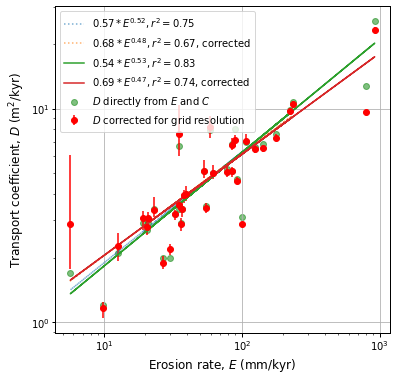

In [13]:
output_file = extract_apparent_D("manny_data_v3",use_brents = False, window_radius = 10, n_iters = 25)
plot_results(output_file)